Model has converged.
Model_7m has converged.
Model_7m_noh has converged.


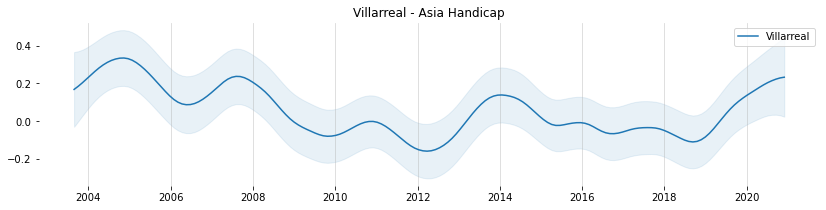

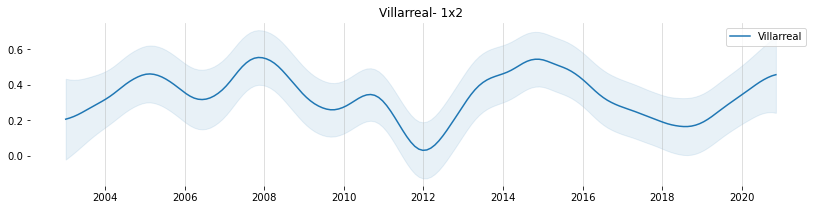

In [6]:

import kickscore as ks

from datetime import datetime
from dateutil.parser import parse

import sqlite3
from sqlite3 import Error
import numpy as np
import matplotlib.pyplot as plt
import itertools

team_name = 'Villarreal'
teams = set()
teams_7m = set()
teams_7m_noh = set()
observations = list()
observations_7m = list()
observations_7m_noh = list()
rows = []
rows_7m = []
cutoff = datetime(2020, 12, 1).timestamp()
conn = None
# try:
#     conn = sqlite3.connect('database.sqlite')
#     cur = conn.cursor()
#     cur.execute("SELECT Datetime, HomeTeam, AwayTeam, FTHG, FTAG FROM football_data Where HomeTeam = 'Liverpool' or AwayTeam = 'Liverpool' or HomeTeam = 'Chelsea' or AwayTeam = 'Chelsea' order by Datetime ASC")

#     rows = cur.fetchall()
# except Error as e:
#     print(e)
try:
    conn = sqlite3.connect('data7m.db')
    cur = conn.cursor()
    cur.execute(f"SELECT Div,Time_, Home, Away, FTHG, FTAG, HTHG, HTAG, Statement FROM soccer_data Where (Home = '{team_name}' or Away = '{team_name}') order by Time_ ASC")

    rows_7m = cur.fetchall()
except Error as e:
    print(e)
# for row in rows:
#     t_date = datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S")
#     if datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S") < parse('01/03/1970'):
#         t = - (parse('01/03/1970') - datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S")).days * 86400 + 25200 + parse(
#             '01/03/1970').timestamp()
#     else:
#         t = datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S").timestamp()
#     #t = datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S").timestamp()
#     if t > cutoff:
#         break
#     teams.add(row[1])
#     teams.add(row[2])
#     if int(row[3]) > int(row[4]):
#         observations.append({
#             "winners": [row[1]],
#             "losers": [row[2]],
#             "t": t,
#         })
#     else:
#         observations.append({
#             "winners": [row[2]],
#             "losers": [row[1]],
#             "t": t,
#         })
for row in rows_7m:
    t_date = datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S")
    if datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S") < parse('01/03/1970'):
        t = - (parse('01/03/1970') - datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S")).days * 86400 + 25200 + parse(
            '01/03/1970').timestamp()
    else:
        t = datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S").timestamp()
    #t = datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S").timestamp()
    if t > cutoff:
        break
    teams_7m.add(row[2])
    teams_7m.add(row[3])
    teams_7m_noh.add(row[2])
    teams_7m_noh.add(row[3])
    if row[8] == "Win" or row[8] == "Win1/2":
        observations_7m.append({
            "winners": [row[2]],
            "losers": [row[3]],
            "t": t,
        })
    if row[8] == "Loss" or row[8] == "Loss1/2":
        observations_7m.append({
            "winners": [row[3]],
            "losers": [row[2]],
            "t": t,
        })
    if int(row[4]) > int(row[5]):
        observations_7m_noh.append({
            "winners": [row[2]],
            "losers": [row[3]],
            "t": t,
        })
    if int(row[4]) < int(row[5]):
        observations_7m_noh.append({
            "winners": [row[3]],
            "losers": [row[2]],
            "t": t,
        })
# It is a bit more convenient to specify lengthscales in yearly units.
seconds_in_year = 365.25 * 24 * 60 * 60

model = ks.BinaryModel()
model_7m = ks.BinaryModel()
model_7m_noh = ks.BinaryModel()
kernel = (ks.kernel.Constant(var=0.03)
        + ks.kernel.Matern32(var=0.138, lscale=1.753*seconds_in_year))
# for team in teams:
#     model.add_item(team, kernel=kernel)

# for obs in observations:
#     model.observe(**obs)

for team in teams_7m:
    model_7m.add_item(team, kernel=kernel)

for obs in observations_7m:
    model_7m.observe(**obs)
    
for team in teams_7m_noh:
    model_7m_noh.add_item(team, kernel=kernel)

for obs in observations_7m_noh:
    model_7m_noh.observe(**obs)

converged = model.fit()
if converged:
    print("Model has converged.")
converged_7m = model_7m.fit()
if converged_7m:
    print("Model_7m has converged.")
converged_7m_noh = model_7m_noh.fit()
if converged_7m:
    print("Model_7m_noh has converged.")
"""fig, ax = model.plot_scores(
        #items=["LAL", "CHI", "BOS"],
        items=["Liverpool"],
        resolution=10/seconds_in_year,
        figsize=(14.0, 3.0),
        timestamps=True)
ax.set_title("World Soccer");"""
def print_plot_scores(model, items, resolution=None, figsize=None, timestamps=False, title="World Soccer"):
    colors = itertools.cycle(plt.cm.tab10(np.linspace(0, 1, 10)))
    if resolution is None:
        first = min(obs.t for obs in model.observations)
        last = max(obs.t for obs in model.observations)
        resolution = 100 / (last - first)
    fig, ax = plt.subplots(figsize=figsize)
    for name in items:
        color = next(colors)
        ts, _, _ = model.item[name].scores
        first = min(ts)
        last = max(ts)
        ts = np.linspace(first, last, num=int(resolution*(last - first)))
        ms, vs = model.item[name].predict(ts)
        std = np.sqrt(vs)
        if timestamps:
            ts = [datetime.fromtimestamp(t) for t in ts]
        ax.plot(ts, ms, color=color, label=name)
        
        ax.fill_between(ts, ms-std, ms+std, color=color, alpha=0.1)
    for spine in ("top", "right", "bottom", "left"):
        ax.spines[spine].set_visible(False)
    ax.grid(axis="x", alpha=0.5)
    ax.legend()
    ax.set_title(title)
# print_plot_scores(model=model,
#         #items=["LAL", "CHI", "BOS"],
#         items=["Liverpool", "Chelsea"],
#         resolution=10/seconds_in_year,
#         figsize=(14.0, 3.0),
#         timestamps=True, title="Liverpool vs Chelsea - 1x2")
print_plot_scores(model=model_7m,
        #items=["LAL", "CHI", "BOS"],
        items=[team_name],
        resolution=10/seconds_in_year,
        figsize=(14.0, 3.0),
        timestamps=True, title=f"{team_name} - Asia Handicap")
print_plot_scores(model=model_7m_noh,
        #items=["LAL", "CHI", "BOS"],
        items=[team_name],
        resolution=10/seconds_in_year,
        figsize=(14.0, 3.0),
        timestamps=True, title=f"{team_name}- 1x2")

In [12]:
p_win, _ = model.probabilities(["Liverpool"], ["Chelsea"], t=datetime(2020, 8, 25).timestamp())
print("  ... in 2020: {:.2f}%".format(100 * p_win))

  ... in 2020: 68.81%
